In [46]:
%pip install ydata_profiling

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from collections import Counter
import seaborn as sns

warnings.filterwarnings('ignore')


# 1 -OverView of the data


Our Datasets contains stats of players in NBA season for every year from 2014 to 2023. 

We also have a rookies datasets which only shows stats of rookies of the same year. A rookie is a new player who never played in The NBA, debuting in a certain season. 

Our goal is to study the carreer of the player staring from his rookie years.



## 1.1 Import Data

In [2]:
# Directory containing all datasets
directory = './dataset_nba'

# List of CSV files in the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Dictionary to memorize DataFrames
dataframes = {}

# Importa i file CSV e assegna loro nomi basati sul titolo del file
for file_name in csv_files:
    # Estrai il titolo del file (senza l'estensione .csv)
    title = os.path.splitext(file_name)[0]

    # Costruisci il percorso completo del file
    file_path = os.path.join(directory, file_name)

    # Leggi il file CSV in un DataFrame e assegna il titolo come chiave
    dataframes[title] = pd.read_csv(file_path)
    dataframes[title]['Season'] = str(title[:4])

dataframes['2014-players'].head(10)


,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ID,Season
0,1,Quincy Acy,SF,23,TOT,63,0,13.4,1.0,2.2,...,2.3,3.4,0.4,0.4,0.4,0.5,1.9,2.7,acyqu01,2014
1,1,Quincy Acy,SF,23,TOR,7,0,8.7,0.9,2.0,...,1.4,2.1,0.6,0.6,0.4,0.3,1.1,2.7,acyqu01,2014
2,1,Quincy Acy,SF,23,SAC,56,0,14.0,1.1,2.3,...,2.4,3.6,0.4,0.3,0.4,0.5,2.0,2.7,acyqu01,2014
3,2,Steven Adams,C,20,OKC,81,20,14.8,1.1,2.3,...,2.3,4.1,0.5,0.5,0.7,0.9,2.5,3.3,adamsst01,2014
4,3,Jeff Adrien,PF,27,TOT,53,12,18.1,2.7,5.2,...,3.8,5.8,0.7,0.5,0.7,0.7,2.0,6.8,adrieje01,2014
5,3,Jeff Adrien,PF,27,CHA,25,0,10.2,0.9,1.6,...,2.2,3.5,0.3,0.3,0.6,0.3,1.4,2.3,adrieje01,2014
6,3,Jeff Adrien,PF,27,MIL,28,12,25.2,4.3,8.4,...,5.3,7.8,1.1,0.6,0.8,1.1,2.6,10.9,adrieje01,2014
7,4,Arron Afflalo,SG,28,ORL,73,73,35.0,6.4,13.8,...,3.2,3.6,3.4,0.5,0.0,2.0,1.9,18.2,afflaar01,2014
8,5,Alexis Ajinça,C,25,NOP,56,30,17.0,2.4,4.4,...,3.3,4.9,0.7,0.4,0.8,1.1,3.3,5.9,ajincal01,2014
9,6,Cole Aldrich,C,25,NYK,46,2,7.2,0.7,1.3,...,2.0,2.8,0.3,0.2,0.7,0.4,0.9,2.0,aldrico01,2014


## 1.2 Features

For Every year for both rookies and players, here are the features in the dataset

- **Player**: Name of the player.
- **Age**: Age during their rookie year.
- **Yrs**: Years played in the NBA.
- **G**: Number of games played.
- **MPTOT**: Total minutes played.
- **FG, FGA**: Field goals made and attempted.
- **3P, 3PA**: Three-point field goals made and attempted.
- **2P, 2PA**: Two-point field goals made and attempted.
- **FT, FTA**: Free throws made and attempted.
- **TRB**: Total rebounds.
- **DRB**: Defensive rebounds.
- **ORB**: Offensive rebounds.
- **AST**: Assists.
- **STL**: Steals.
- **BLK**: Blocks.
- **PF**: Personal fouls.
- **PTS**: Points per game.
- **FG%**, **3P%**,**2P%**, **FT%**, **eFG%**: Shooting percentages.
- **ID**: Unique identifier for the player.
- **Season**: Season Played.
for the player.

### 1.3 Visualize data

We can get players or rookies from a particular year

In [3]:
def get_players_data(year):
    """
     Return the dataset of a particular year for all players 
    """
    return dataframes[f'{year}-players']

def get_rookies_data(year):
    """
     Return the dataset of a particular year for  only rookies drafted that year
    """
    return dataframes[f'{year}-rookies']

In [4]:
players_2014 = get_players_data(2014)
players_2014.head(5)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ID,Season
0,1,Quincy Acy,SF,23,TOT,63,0,13.4,1.0,2.2,...,2.3,3.4,0.4,0.4,0.4,0.5,1.9,2.7,acyqu01,2014
1,1,Quincy Acy,SF,23,TOR,7,0,8.7,0.9,2.0,...,1.4,2.1,0.6,0.6,0.4,0.3,1.1,2.7,acyqu01,2014
2,1,Quincy Acy,SF,23,SAC,56,0,14.0,1.1,2.3,...,2.4,3.6,0.4,0.3,0.4,0.5,2.0,2.7,acyqu01,2014
3,2,Steven Adams,C,20,OKC,81,20,14.8,1.1,2.3,...,2.3,4.1,0.5,0.5,0.7,0.9,2.5,3.3,adamsst01,2014
4,3,Jeff Adrien,PF,27,TOT,53,12,18.1,2.7,5.2,...,3.8,5.8,0.7,0.5,0.7,0.7,2.0,6.8,adrieje01,2014


In [5]:
from ydata_profiling import ProfileReport
profile = ProfileReport(players_2014, title="Profiling report")


In [6]:
#profile.to_widgets()

## 2- Data Preprocessing

### 2.1 Standadize Player roles

In [7]:
#Defining a custom function to standardize roles
def standadize_role(role):
    roles = {
        "SG-SF": "SG",
        "SF-SG": "SF",
        "SG-PG": "SG",
        "PF-SF": "PF",
        "C-PF": "C",
        "SF-PF": "SF",
        "PF-C": "PF"
        
    }
    return roles.get(role, role)

### 2.1 Aggregate stats for each players for a given season

Some players change teams during the year so we need to aggregate their stats, by performing adequate operations 

In [8]:
from scipy import stats

# Defining functions for aggregation
def weighted_average(group, avg_name, weight_name):
    """ Calculate weighted average for a group. """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return 0

def impute_missing_values(df, cols= ["3P%","FT%","2P%","FG%"]):
    # For shooting percentages, we can replace missing values with 0, assuming missing values indicate no attempts or no successes
    for col in cols:
        df[col] = df[col].fillna(0, inplace=False)

    return df
    


# Aggregating the data
def aggregate_stats(df):
    aggregated_stats = df.groupby('ID').agg({

        ## quantified values
        'G': 'sum',  # Summing up games played
        'GS': 'sum',  # Summing up games started
        'FG': 'sum',  # Summing up field goals
        'FGA': 'sum', # Summing up field goal attempts
        '2P': 'sum',  # Summing up two-point field goals
        '3P': 'sum',  # Summing up three-point field goals
        '2PA': 'sum', # Summing up two-point attempts
        '3PA': 'sum', # Summing up three-point attempts
        'FT': 'sum',  # Summing up free throws
        'FTA': 'sum', # Summing up free throw attempts
        'ORB': 'sum', # Summing up offensive rebounds
        'DRB': 'sum', # Summing up defensive rebounds
        'TRB': 'sum', # Summing up total rebounds
        'AST': 'sum', # Summing up assists
        'STL': 'sum', # Summing up steals
        'BLK': 'sum', # Summing up blocks
        'TOV': 'sum', # Summing up turnovers
        'PF': 'sum',  # Summing up personal fouls
        
        ## Percentage and averaged values 
        'MP': lambda x: weighted_average(df.loc[x.index], 'MP', 'G'),  # Weighted average for minutes per game
        'PTS': lambda x: weighted_average(df.loc[x.index], 'PTS', 'G'),  # Weighted average for points per game
        'FG%': lambda x: weighted_average(df.loc[x.index], 'FG%', 'FGA'), # Weighted average for field goal percentage
        '3P%': lambda x: weighted_average(df.loc[x.index], '3P%', '3PA'), # Weighted average for three-point percentage
        '2P%': lambda x: weighted_average(df.loc[x.index], '2P%', '2PA'), # Weighted average for two-point percentage
        'FT%': lambda x: weighted_average(df.loc[x.index], 'FT%', 'FTA'),  # Weighted average for free throw percentage

        ## Unique or fixed values
        'Season': lambda x: x.mode().iloc[0], # Season 
        'Pos' : lambda x: x.mode().iloc[0] # Most played position of the player
    }).reset_index()

    #impute missing values
    aggregated_stats = impute_missing_values(aggregated_stats)

    # Calculate eFG% after imputing missing values
    aggregated_stats['eFG%'] = (aggregated_stats['FG'] + 0.5 * aggregated_stats['3P']) / aggregated_stats['FGA']

    return aggregated_stats



In [9]:
players_2014_agg = aggregate_stats(players_2014)

In [10]:
players_2014_agg.head(10)

,ID,G,GS,FG,FGA,2P,3P,2PA,3PA,FT,...,PF,MP,PTS,FG%,3P%,2P%,FT%,Season,Pos,eFG%
0,acyqu01,126,0,3.0,6.5,2.6,0.4,5.4,1.1,1.8,...,5.0,13.405556,2.700000,0.457415,0.339455,0.482000,0.647815,2014,SF,0.492308
1,adamsst01,81,20,1.1,2.3,1.1,0.0,2.3,0.0,1.0,...,2.5,14.800000,3.300000,0.503000,0.000000,0.503000,0.581000,2014,C,0.478261
2,adrieje01,106,24,7.9,15.2,7.9,0.0,15.2,0.0,4.2,...,6.0,18.112264,6.821698,0.520395,0.000000,0.520395,0.636939,2014,PF,0.519737
3,afflaar01,73,73,6.4,13.8,4.6,1.8,9.7,4.1,3.8,...,1.9,35.000000,18.200000,0.459000,0.427000,0.473000,0.815000,2014,SG,0.528986
4,ajincal01,56,30,2.4,4.4,2.4,0.0,4.4,0.0,1.0,...,3.3,17.000000,5.900000,0.546000,0.000000,0.548000,0.836000,2014,C,0.545455
5,aldrico01,46,2,0.7,1.3,0.7,0.0,1.3,0.0,0.6,...,0.9,7.200000,2.000000,0.541000,0.000000,0.541000,0.867000,2014,C,0.538462
6,aldrila01,69,69,9.4,20.6,9.4,0.0,20.4,0.2,4.3,...,2.1,36.200000,23.200000,0.458000,0.200000,0.461000,0.822000,2014,PF,0.456311
7,allenla01,130,4,5.6,12.2,5.5,0.0,11.8,0.5,1.4,...,5.0,16.486923,4.702308,0.454443,0.154000,0.466017,0.646957,2014,PF,0.459016
8,allenra02,73,9,3.3,7.4,1.7,1.6,3.2,4.2,1.4,...,1.6,26.500000,9.600000,0.442000,0.375000,0.530000,0.905000,2014,SG,0.554054
9,allento01,55,28,3.7,7.5,3.5,0.2,6.7,0.9,1.4,...,2.2,23.200000,9.000000,0.494000,0.234000,0.527000,0.628000,2014,SG,0.506667


### 2.3 Build our dataset over a number of seasons

To study the progression of a rookie , we need a dataset get rookies drafted a certain year and their progress over the next years

In [11]:
def get_rookies_data_from(start_year, current_year):
    """
     Return the dataset of a range of  years for all rookies drafted in a particular year.
    """

    rookies_ids = get_rookies_data(start_year)["ID"]
    df_final = pd.DataFrame()
    ## considering a start year 
    ## we retrieve data of all successives years for this same rookies
    for year in range(start_year, current_year+1):
        df_players_of_year = aggregate_stats(get_players_data(year))
        df_start_year_rookies = df_players_of_year[df_players_of_year['ID'].isin(rookies_ids)]
        df_final = pd.concat([df_start_year_rookies, df_final], ignore_index=True)
        
    return df_final



In [12]:
# here we get rookies drafted in 2017 and following seasons
rookies_data = get_rookies_data_from(2017,2023)
rookies_data.head(10)

,ID,G,GS,FG,FGA,2P,3P,2PA,3PA,FT,...,PF,MP,PTS,FG%,3P%,2P%,FT%,Season,Pos,eFG%
0,beaslma01,162,54,13.4,34.1,4.9,8.5,10.1,23.9,1.8,...,3.9,25.834568,12.680864,0.394452,0.356515,0.483436,0.743,2023,SG,0.517595
1,bertada01,45,1,1.5,3.6,0.3,1.2,0.4,3.1,0.3,...,1.2,10.900000,4.600000,0.431000,0.390000,0.737000,0.867,2023,PF,0.583333
2,brogdma01,67,0,5.3,10.9,3.3,2.0,6.5,4.4,2.4,...,1.6,26.000000,14.900000,0.484000,0.444000,0.510000,0.870,2023,PG,0.577982
3,brownja02,67,67,10.1,20.6,7.7,2.4,13.4,7.3,3.9,...,2.6,35.900000,26.600000,0.491000,0.335000,0.576000,0.765,2023,SF,0.548544
4,dunnkr01,22,3,5.3,9.8,4.5,0.8,8.2,1.6,1.9,...,2.6,25.800000,13.200000,0.537000,0.472000,0.550000,0.774,2023,PG,0.581633
5,embiijo01,66,66,11.0,20.1,10.0,1.0,17.1,3.0,10.0,...,3.1,34.600000,33.100000,0.548000,0.330000,0.587000,0.857,2023,C,0.572139
6,finnedo01,132,132,8.8,22.7,3.7,5.0,7.5,15.2,2.1,...,6.7,30.413636,8.325758,0.386727,0.333809,0.493533,0.765,2023,PF,0.497797
7,forbebr01,25,0,1.2,3.3,0.6,0.6,1.5,1.8,0.6,...,0.9,10.700000,3.600000,0.361000,0.304000,0.432000,1.000,2023,SG,0.454545
8,hernaju01,42,10,1.1,2.7,0.7,0.4,1.1,1.6,0.2,...,1.0,14.600000,2.900000,0.421000,0.254000,0.660000,0.563,2023,PF,0.481481
9,hernawi01,38,2,2.3,4.4,2.3,0.1,4.2,0.3,2.1,...,1.7,12.100000,6.900000,0.527000,0.273000,0.544000,0.779,2023,C,0.534091


From this dataset we retain only rookies present for at a certain numbers of season

In [13]:
def filter_players(df, min_season):
    season_count = df.groupby('ID')['Season'].nunique()

    # Filter to get IDs with min_season or more seasons
    ids_with_min_season = season_count[season_count >= min_season].index
    
    # Step 3: Filter the original DataFrame to include only those IDs
    df_filtered = df[df['ID'].isin(ids_with_min_season)]
    return df_filtered

In [14]:
rookies_data_filtered = filter_players(rookies_data, min_season= 3)

In [15]:
rookies_data_filtered.shape

(317, 28)

## 3 Features Engineering

### 3.1 Normalize Stats per game  

Because every player does not play same amount of game time . We can normalize the main Stats .

In [16]:
def normalize_stats_per_game(df):
    df['PTS_per_game'] = df['PTS'] / df['G']
    df['AST_per_game'] = df['AST'] / df['G']
    df['REB_per_game'] = df['TRB'] / df['G']
    return df

In [17]:

# normalize data
normalized_rookies_data = normalize_stats_per_game(rookies_data_filtered)

# Display the first few rows of the combined dataset and check for any inconsistencies
normalized_rookies_data.head(), normalized_rookies_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 317 entries, 0 to 363
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            317 non-null    object 
 1   G             317 non-null    int64  
 2   GS            317 non-null    int64  
 3   FG            317 non-null    float64
 4   FGA           317 non-null    float64
 5   2P            317 non-null    float64
 6   3P            317 non-null    float64
 7   2PA           317 non-null    float64
 8   3PA           317 non-null    float64
 9   FT            317 non-null    float64
 10  FTA           317 non-null    float64
 11  ORB           317 non-null    float64
 12  DRB           317 non-null    float64
 13  TRB           317 non-null    float64
 14  AST           317 non-null    float64
 15  STL           317 non-null    float64
 16  BLK           317 non-null    float64
 17  TOV           317 non-null    float64
 18  PF            317 non-null    float

(          ID    G  GS    FG   FGA   2P   3P   2PA   3PA   FT  ...       FG%  \
 0  beaslma01  162  54  13.4  34.1  4.9  8.5  10.1  23.9  1.8  ...  0.394452   
 1  bertada01   45   1   1.5   3.6  0.3  1.2   0.4   3.1  0.3  ...  0.431000   
 2  brogdma01   67   0   5.3  10.9  3.3  2.0   6.5   4.4  2.4  ...  0.484000   
 3  brownja02   67  67  10.1  20.6  7.7  2.4  13.4   7.3  3.9  ...  0.491000   
 4   dunnkr01   22   3   5.3   9.8  4.5  0.8   8.2   1.6  1.9  ...  0.537000   
 
         3P%       2P%    FT%  Season  Pos      eFG%  PTS_per_game  \
 0  0.356515  0.483436  0.743    2023   SG  0.517595      0.078277   
 1  0.390000  0.737000  0.867    2023   PF  0.583333      0.102222   
 2  0.444000  0.510000  0.870    2023   PG  0.577982      0.222388   
 3  0.335000  0.576000  0.765    2023   SF  0.548544      0.397015   
 4  0.472000  0.550000  0.774    2023   PG  0.581633      0.600000   
 
    AST_per_game  REB_per_game  
 0      0.027160      0.064198  
 1      0.011111      0.026667

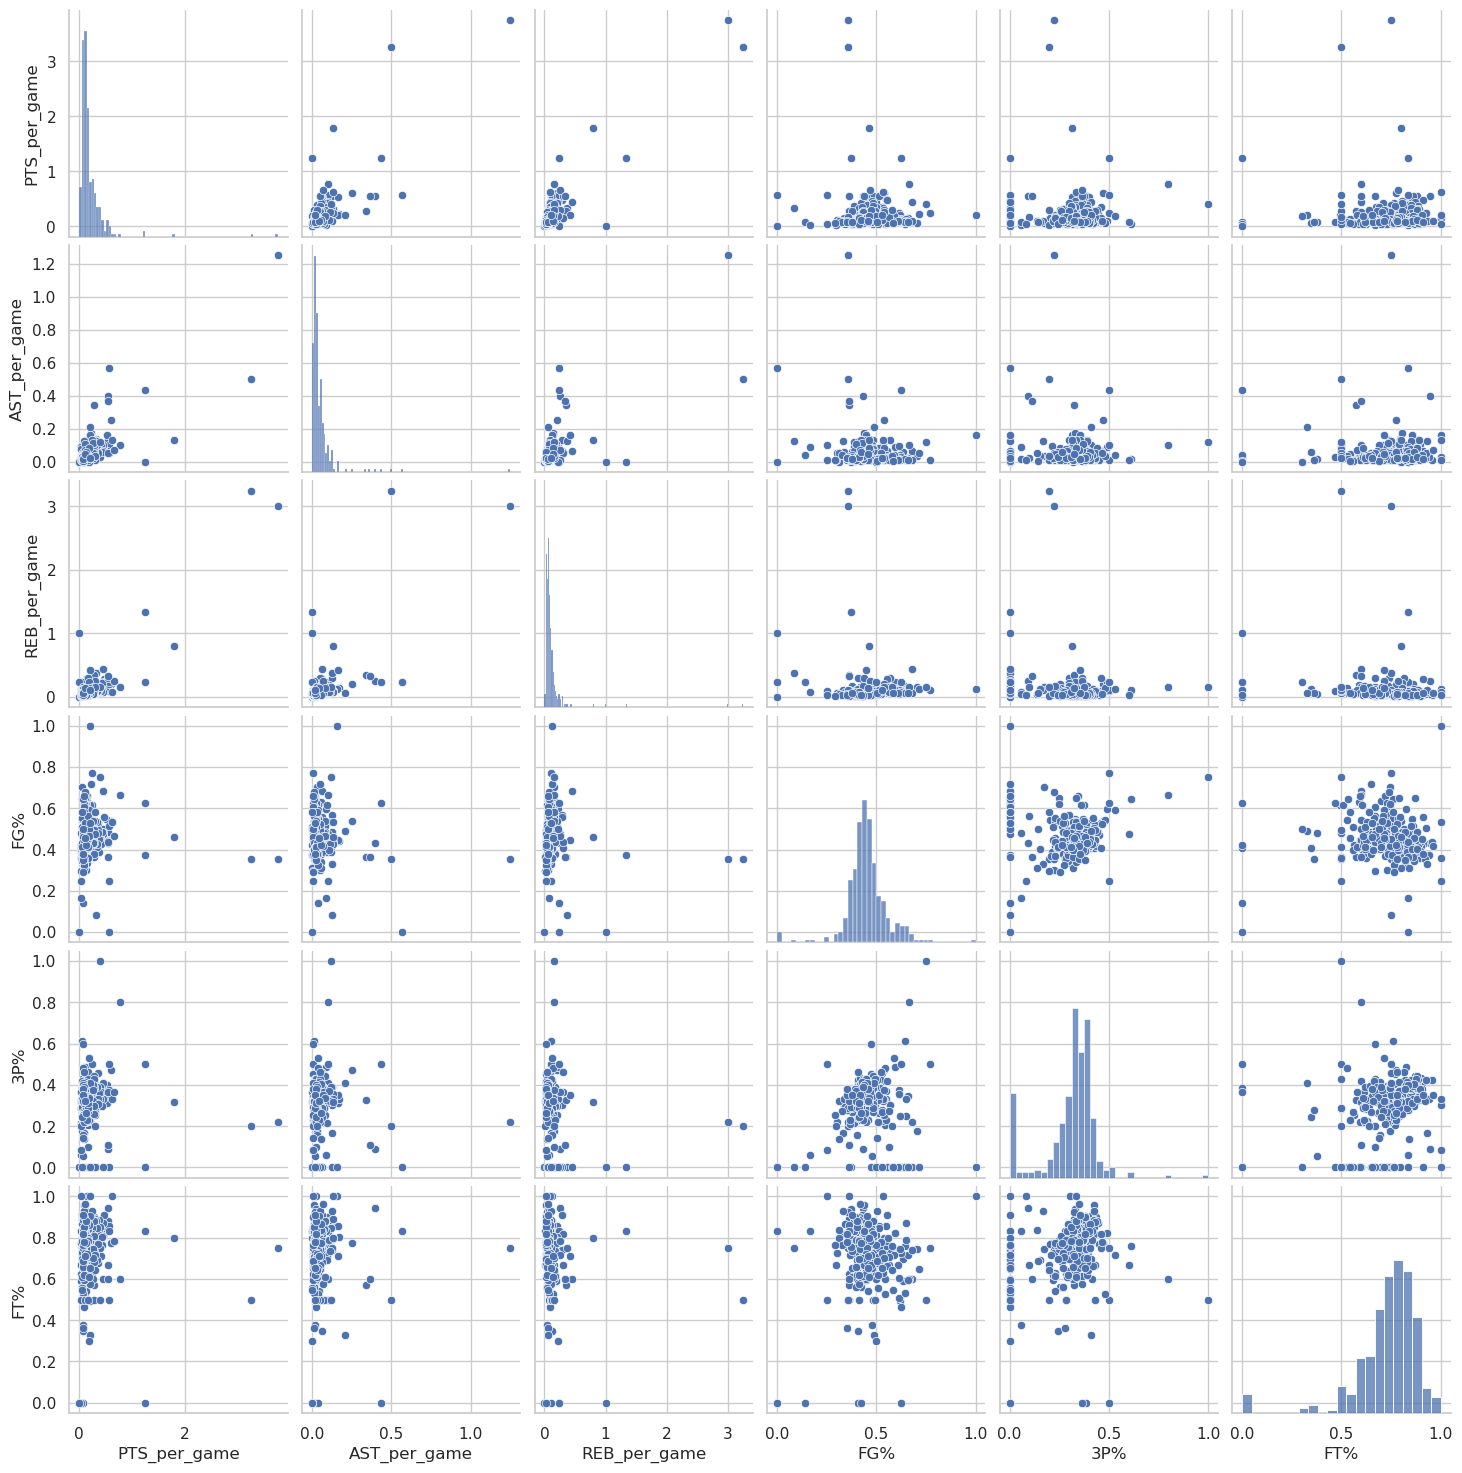

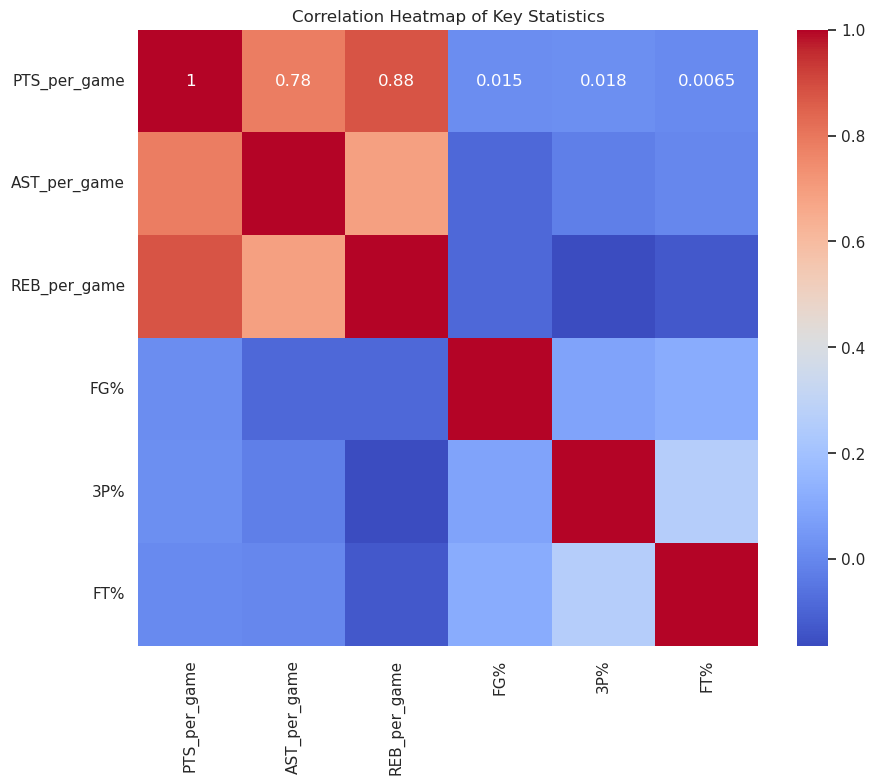

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the visualisation style
sns.set(style="whitegrid")

# Selecting a few key statistics for exploration
key_stats = ['PTS_per_game', 'AST_per_game', 'REB_per_game', 'FG%', '3P%', 'FT%']

# Pairplot to visualize relationships between key stats
pairplot_data = normalized_rookies_data[key_stats]
sns.pairplot(pairplot_data)
plt.show()

# Correlation heatmap
corr = pairplot_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Key Statistics")
plt.show()


## Correlation Matrix

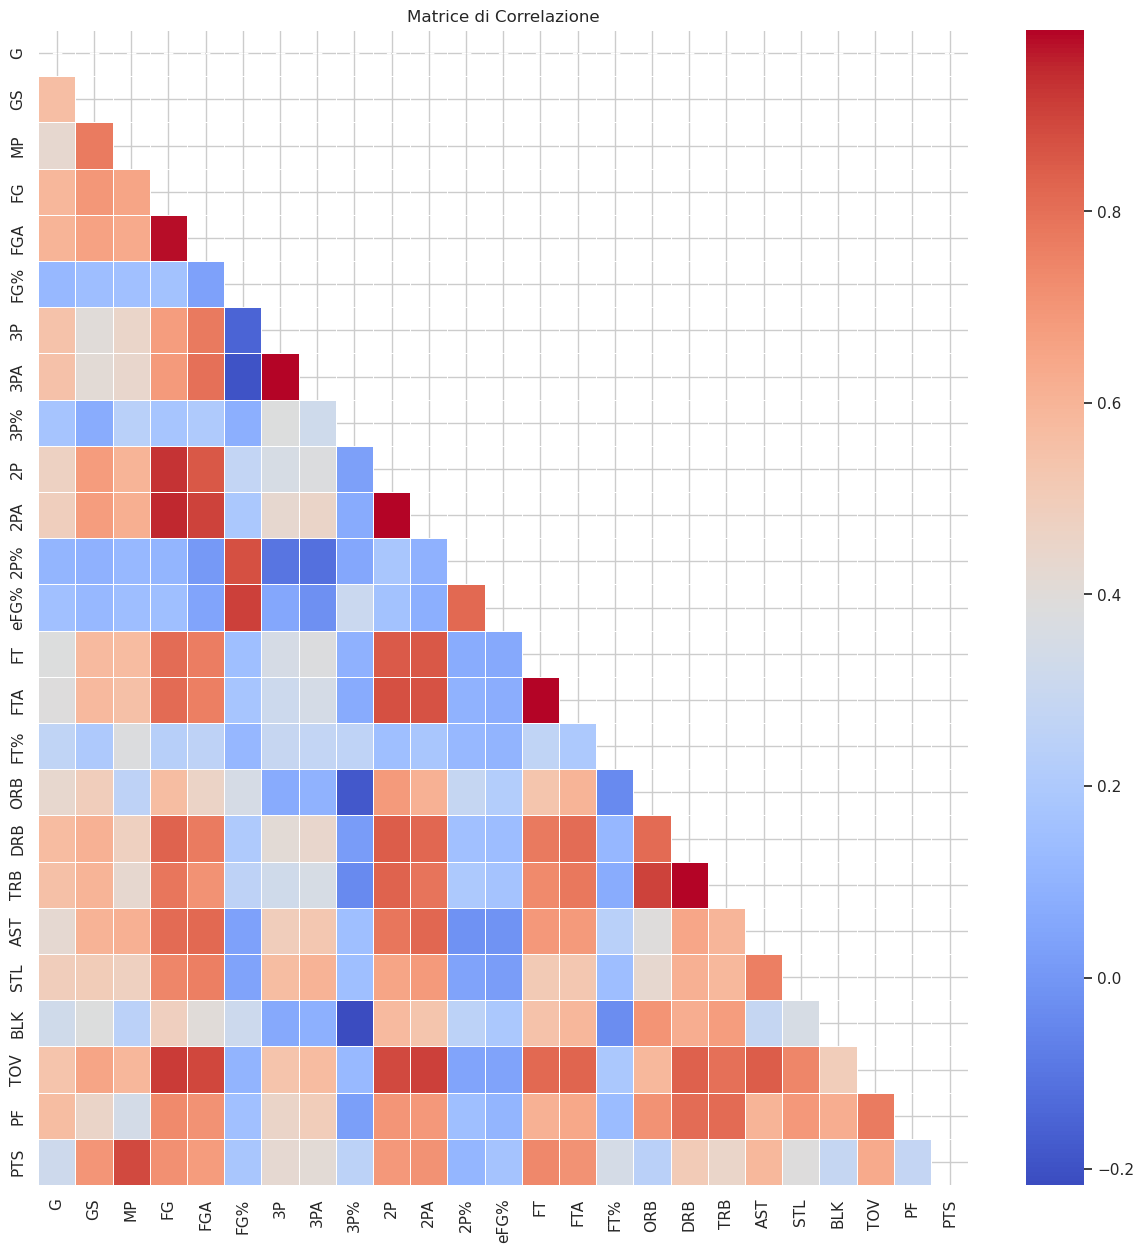

In [19]:


# Creazione di un DataFrame con i tuoi dati
# Supponendo che i tuoi dati siano già presenti in un DataFrame chiamato 'df'

# Creazione di una sottoinsieme del DataFrame con le colonne di interesse
columns_of_interest = ['G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%',
                        'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']

subset_df = normalized_rookies_data[columns_of_interest]

# Calcolo della matrice di correlazione
correlation_matrix = subset_df.corr()

# Creazione di una matrice con la stessa forma di quella di correlazione ma con valori NaN
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Creazione di un heatmap per visualizzare solo la metà superiore della matrice di correlazione
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, mask=mask)
plt.title("Matrice di Correlazione")
plt.show()


**Strong Correlations with Points (PTS)**:
Field goals (FG), field goal attempts (FGA), minutes played (MP), and free throws (FT) show strong positive correlations with points scored. This suggests that players who have more playing time and shooting opportunities tend to score more.


**Other Notable Correlations**: Assists (AST), rebounds (TRB), and steals (STL) also correlate positively with points, indicating that players who contribute significantly in these areas often score higher points.




## Graph to show the differences between the average PTS RBS and AST in year 1,2,3 in NBA

In [40]:
start_year = 2017
year_1=normalized_rookies_data[normalized_rookies_data["Season"]==str(start_year)]
year_2=normalized_rookies_data[normalized_rookies_data["Season"]==str(start_year+1)]
year_3=normalized_rookies_data[normalized_rookies_data["Season"]==str(start_year+2)]

PTS = []
AST = []
REB = []

for i in range(3):
    data = normalized_rookies_data[normalized_rookies_data["Season"]==str(start_year+i)]
    PTS.append(data["PTS"].mean())
    AST.append(data["AST"].mean())
    REB.append(data["TRB"].mean())

# We computed the average points rebounds and assists per game respectively in year 1 2 and 3.

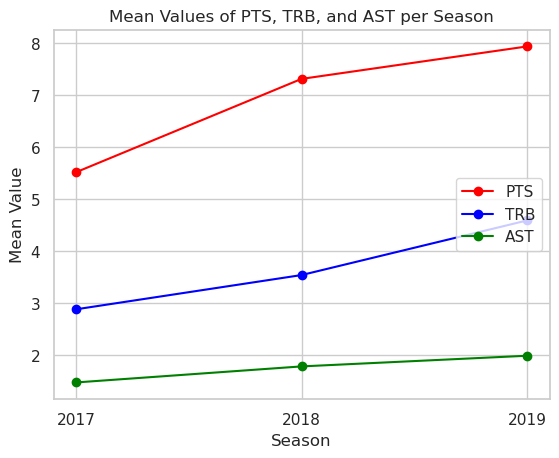

In [41]:
fig, ax1 = plt.subplots()

# Plot the PTS data as a line with red color
ax1.plot(['2017','2018','2019'], PTS, color='red', label='PTS', marker = 'o')

# Plot the TRB data as a line with blue color
ax1.plot(['2017','2018','2019'], REB, color='blue', label='TRB', marker = 'o')

# Plot the AST data as a line with green color
ax1.plot(['2017','2018','2019'], AST, color='green', label='AST', marker = 'o')

plt.xticks(['2017','2018','2019'])
# Add a legend
ax1.legend(loc='center right')

# Set the x-axis label and y-axis label
ax1.set_xlabel('Season')
ax1.set_ylabel('Mean Value')

# Set the title of the graph
ax1.set_title('Mean Values of PTS, TRB, and AST per Season')
plt.show()

# pt assist rimbalzi

* The graph above shows how the points made the rebounds and assists grow every year. In particular the increase of the points per game is the higher between the three, starting from an average of 6.04 Points per game and reaching the value of 8.48 in year 3.

## Histograms of Points, Rebounds and Assists per game

In [31]:
def plot(df):
  # Set the aesthetic style of the plots
  sns.set_style("whitegrid")

  # Create a figure with multiple subplots
  fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

  # Points per game distribution
  sns.histplot(df['PTS'], kde=True, ax=axes[0, 0], bins=30, color='skyblue')
  axes[0, 0].set_title('Distribution of Points per Game')

  # Rebounds per game distribution
  sns.histplot(df['TRB'], kde=True, ax=axes[0, 1], bins=30, color='lightgreen')
  axes[0, 1].set_title('Distribution of Rebounds per Game')

  # Assists per game distribution
  sns.histplot(df['AST'], kde=True, ax=axes[0, 2], bins=30, color='salmon')
  axes[0, 2].set_title('Distribution of Assists per Game')

  # Scatter plot of Points vs Rebounds
  sns.scatterplot(x='PTS', y='TRB', data=df, ax=axes[1, 0], color='purple')
  axes[1, 0].set_title('Points vs Rebounds')

  # Scatter plot of Points vs Assists
  sns.scatterplot(x='PTS', y='AST', data=df, ax=axes[1, 1], color='orange')
  axes[1, 1].set_title('Points vs Assists')

  # Correlation heatmap
  corr = df[['PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']].corr()
  sns.heatmap(corr, annot=True, cmap='coolwarm', ax=axes[1, 2])
  axes[1, 2].set_title('Correlation Heatmap')

  plt.tight_layout()
  plt.show()

* Year 1

In [ ]:
# year_1[["PTS","AST","TRB"]].hist(figsize=(10, 10), bins=40,density=True)
# plt.show()

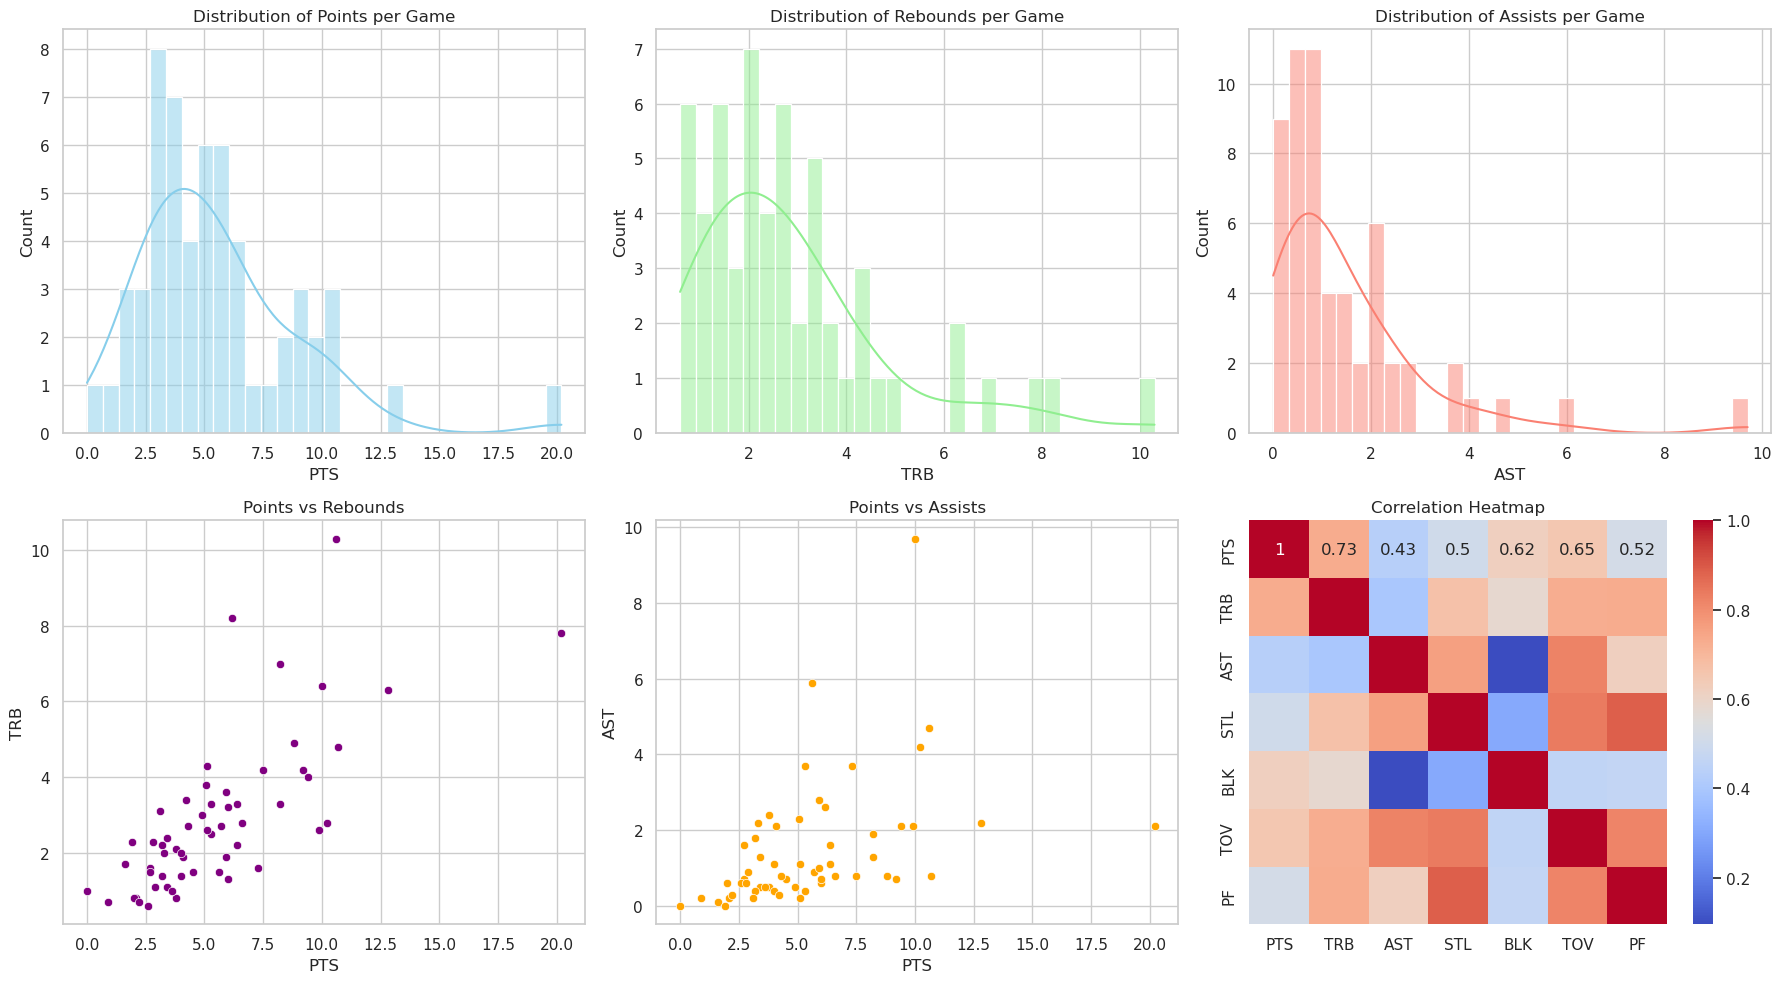

In [32]:
plot(year_1)

* Year 2

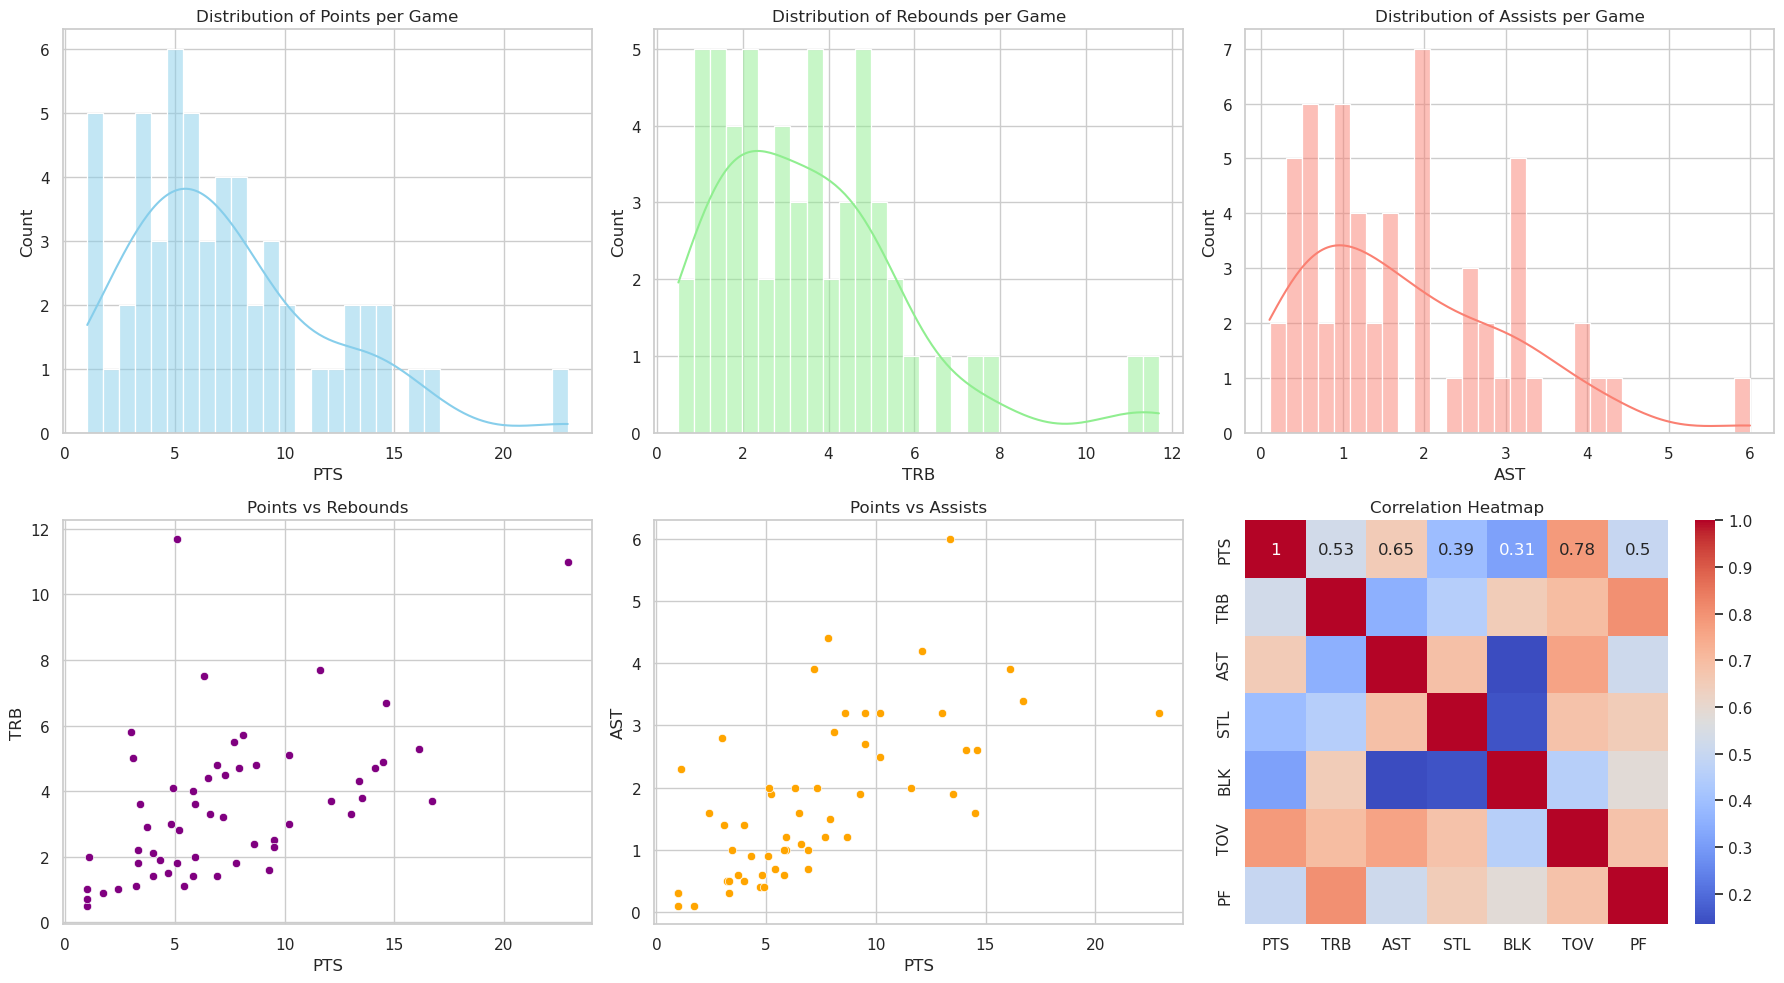

In [33]:
plot(year_2)

* Year 3

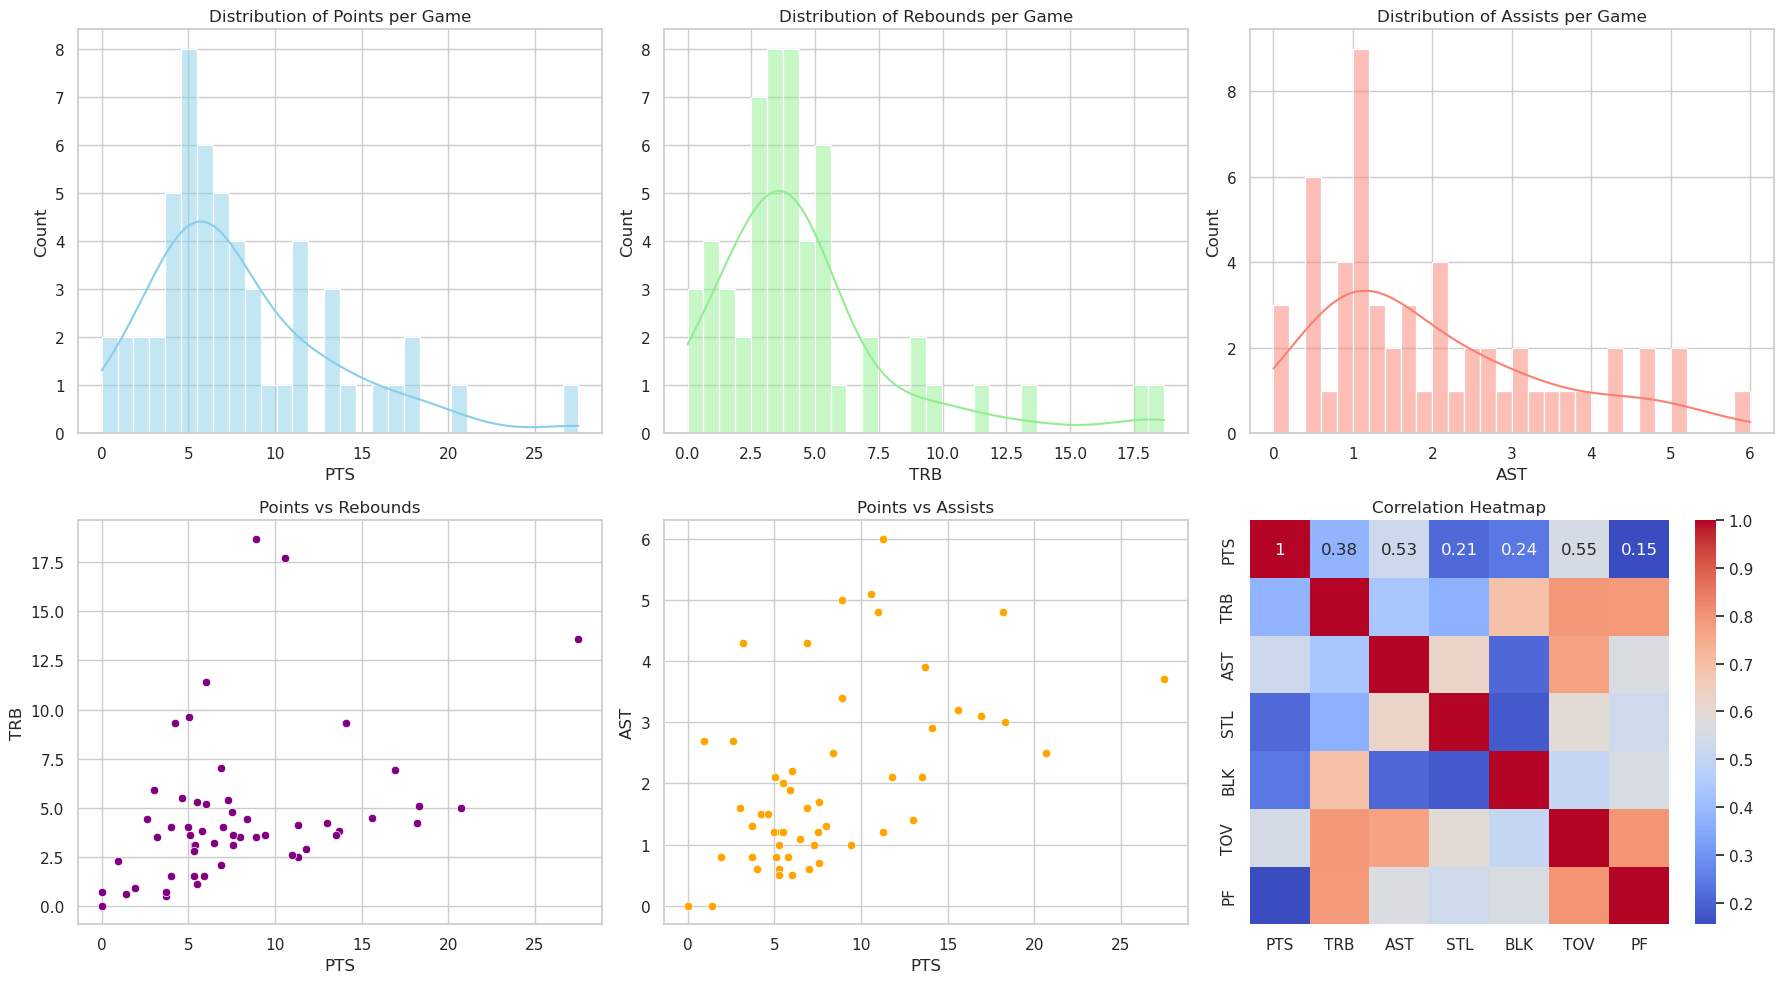

In [34]:
plot(year_3)

### Histogram Observations:



**Points Per Game (PTS)**: The distribution is right-skewed, meaning most players score below the average, with a few high-scoring outliers.


**Assists Per Game (AST)**: Similar to points, the distribution is right-skewed, with most players recording fewer assists.


**Rebounds Per Game (TRB)**: This distribution also shows a right skew, with fewer players having high rebound numbers.
Steals Per Game (STL): Steals are relatively rare events, and the distribution reflects this with most players having low steal numbers.

The constant growth we saw before is noticeable also in the histograms, the shape of the graphs is pretty similar to a Normal distribution with a mean that increases each. It is pretty clear that there are some outliers and the number of them is higher each year, in fact just a little number of players perform at a elitè level in their rookie season.

## A glimpse of the outliers

* Year 1

In [ ]:
Q1_pts_1 = year_1["PTS"].quantile(0.25)
Q3_pts_1 = year_1["PTS"].quantile(0.75)
IQR = Q3_pts_1- Q1_pts_1
# We used the interquartile interval to spot the outliers

PTS_outliers_1 = year_1[["PTS","Player","G"]][(year_1["PTS"] < (Q1_pts_1 - 1.5 * IQR)) | (year_1["PTS"] > (Q3_pts_1 + 1.5 * IQR))]
PTS_outliers_1.sort_values("PTS",ascending=False) # ATTENZIONE AL NUMERO DI PARTITE GIOCATE!!!

In [ ]:
# We do the same with AST and REB

Q1_ast_1 = year_1["AST"].quantile(0.25)
Q3_ast_1 = year_1["AST"].quantile(0.75)
IQR = Q3_ast_1- Q1_ast_1
# We used the interquartile interval to spot the outliers

AST_outliers_1 = year_1[["AST","Player","G"]][(year_1["AST"] < (Q1_ast_1 - 1.5 * IQR)) | (year_1["AST"] > (Q3_ast_1 + 1.5 * IQR))]
AST_outliers_1.sort_values("AST",ascending=False)

In [ ]:
Q1_reb_1 = year_1["TRB"].quantile(0.25)
Q3_reb_1 = year_1["TRB"].quantile(0.75)
IQR = Q3_reb_1- Q1_reb_1
# We used the interquartile interval to spot the outliers

REB_outliers_1 = year_1[["TRB","Player","G"]][(year_1["TRB"] < (Q1_reb_1 - 1.5 * IQR)) | (year_1["TRB"] > (Q3_reb_1 + 1.5 * IQR))]
REB_outliers_1.sort_values("TRB",ascending=False)


# ........year 2,3 bla bla

## Example: Luka Dončić

* As we saw from the previous analysis some players seem to perform on a different level, we want our model to predict correctly the careers of players with those type of stats in year 1, we will take a look to the stats of one of the best rookies ever: Luka Dončić and see how different he performed compared to the average rookie stats through year 1,2 and 3

In [ ]:
categories=["PTS","AST","TRB"]
player_outlier = [21.2,6.0,7.8]
average_players=[PTS1,AST1,REB1]


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()


fig.add_trace(go.Scatterpolar(
      r=player_outlier,
      theta=categories,
      fill='toself',
      name='Luka Dončić'
))
fig.add_trace(go.Scatterpolar(
      r=average_players,
      theta=categories,
      fill='toself',
      name='Average rookies'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=False,
      showline=False,
      color='sandybrown'
    )),
  showlegend=True,
  height=800,  # Altezza del grafico
  width=800,

)

fig.show()


***************************************************************************************************************************************************************************